In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
    
except ModuleNotFoundError:    
    # settings local:
    %run "../../../common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed


[<img src="https://www.digitalhouse.com/ar/logo-DH.png" width="400" height="200" align='right'>](http://digitalhouse.com.ar/)

# Regresión Lineal con scikit-learn y statsmodels

## Resumen
<div id="caja4" style="float:left;width: 100%;">
  <div style="float:right;width: 15%;"><img src="../../../common/icons/en_resumen.png" style="align:right"/> </div>
  <div style="float:right;width: 85%;"><label></label></div>
</div>



Hoy vamos a investigar un dataset clásico en el mundo de data science (DS), el dataset de propiedades de la ciudad de  Boston. 

En particular aplicaremos la regresion lineal a un problema inmobiliario. Sin embargo, descubriremos que esta técnica puede ser muy útil en otras areas como: marketing, finanzas, biología, petroquímica, etc. A lo largo de esta notebook vamos a usar dos librerías (o paquetes) diferentes, para los que pueden ver ejemplos en la documentación oficial.

* statsmodels -- [docs regresión lineal](http://statsmodels.sourceforge.net/devel/examples/#regression)
* scikit-learn -- [docs regresión lineal](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

## 1. Introducción

Ya nos hemos familizarizado bastante con scikit-learn, e iremos viendo la potencia de la misma. Sin embargo también debemos saber que  la librería incluye algunos datasets para testear y practicar los algoritmos que tiene implementado. El listado de los datasets que podemos encontrar los podes ver [aquí](https://scikit-learn.org/stable/datasets/index.html). 

Para cargar el dataset con el que vamos a trabajar hoy simplemente hay que importarlo desde sklearn.datasets

In [2]:
# Importamos algunas librerias para graficar.
%matplotlib inline
from matplotlib import pyplot as plt


In [3]:
# importamos el modelo lineal y algunas funciones para calcular la bondad de ajuste.
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## 2. Conociendo el formato de los datsets de scikit-learn

In [4]:
# Para cargar el dataset lo importamos desde scikit-learn.
from sklearn import datasets
data = datasets.load_boston()

In [5]:
# imprimimos la ayuda para ver todos los datasets dispoibles.
datasets??

Type:        module
String form: <module 'sklearn.datasets' from 'C:\\Users\\mbeati\\Anaconda3\\envs\\dhdsblend\\lib\\site-packages\\sklearn\\datasets\\__init__.py'>
File:        c:\users\mbeati\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\datasets\__init__.py
Source:     
"""
The :mod:`sklearn.datasets` module includes utilities to load datasets,
including methods to load and fetch popular reference datasets. It also
features some artificial data generators.
"""
from ._base import load_breast_cancer
from ._base import load_boston
from ._base import load_diabetes
from ._base import load_digits
from ._base import load_files
from ._base import load_iris
from ._base import load_linnerud
from ._base import load_sample_images
from ._base import load_sample_image
from ._base import load_wine
from ._base import get_data_home
from ._base import clear_data_home
from ._covtype import fetch_covtype
from ._kddcup99 import fetch_kddcup99
from ._lfw import fetch_lfw_pairs
from ._lfw import fet

Para echarles un vistazo podemos ver con el atributo DESCR la descripcion del dataset. 

In [6]:
print (data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

El dataset lista 14 atributos que describen hogares de boston. Como dice la descripción el valor medio es el atributo que habitualmente se utiliza como variable objetivo. En nuestro caso mas sencillo es el atributo que intentaremos predecir a partir de otras variables explicativas. Cada instancia del dataframe describe un área suburbana o municipio de Boston ( Boston Standard Metropolitan Statistical Area (SMSA)) en 1970.

In [7]:
type(data)

sklearn.utils.Bunch

> Un Bunch es un diccionario de Python dictionary que provee acceso utilizando atributos. Un Bunch es una subclase de dict y soporta todos los métodos de un dict.

In [8]:
#Dentro del Bunch podemos obtener diferentes atributos de nuestro dataset.
# Los nombres de las columnas 
print (data.feature_names)
# Los predictores o variables independientes.
print (data.data[0])
# La variable objetivo o variable dependiente.
print (data.target[0])

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00]
24.0


Como pueden ver, Scikit-learn ya separó el precio medio  de las casas del resto de las variables. El atributo target u objetivo (data.target) es nuestra variable dependiente intentaremos predecir a partir de los demás.

## 3. Estimando el modelo de regresión lineal

Primero, pongamos los datos en un data frame y asegurémonos de que esté todo cargado correctamente

In [9]:
import numpy as np
import pandas as pd
df = pd.DataFrame(data.data, columns=data.feature_names)

# Ponemos el target (precio de las casas -- MEDV) en otro DataFrame
targets = pd.DataFrame(data.target, columns=["MEDV"])

# Miremos las primeras filas de datos
display (df.head())
display (targets.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


El primer ejercicio podria ser: Seleccionar variables una por una y ver su relación con la variable objetivo.

* Identifiquemos visualmente algunas variables que parezcan relacionadas al precio. Por ejemplo: RM and LSTAT. 

* Hagamos un análisis por separado y luego juntas.

## Relación entre RM y MEDV

 Generamos las matrices de variables explicativas o independientes y el target
 Primero seleccionamos como variable explicativa a RM como numero promedio de habitaciones.
 
 
 
 
 
 
 
 
 
 ### Para Pensar...
 
 <div id="caja9" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_seguir_pensando.png" style="align:left"/> </div>
  <div style="float:left;width: 85%;"><label>Tiene sentido que exista una relacion lineal entre el numero promedio de habitaciones y el precio promedio?.
</label></div>
</div>
 

In [10]:
# Seleccionamos la variable predictora y la objetivo.
X = df[["RM"]]
y = targets["MEDV"]

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm = linear_model.LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model = lm.fit(X, y)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions = lm.predict(X)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model.intercept_)
print ('RM=', ' ', model.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', model.score(X, y))

Intercepto=   -34.67062077643857
RM=   [9.10210898]
R2_train=   0.4835254559913343


In [11]:
# Generamos una función que resume los coeficientes, el intercepto y el R2
# "model" = objeto con el modelo
# "X" = matrix de variables independientes

def sum_mod(model, X):
    a = pd.DataFrame(model.coef_ , X.columns.values)
    a = a.append(pd.DataFrame([model.intercept_, model.score(X, y)], index=['Intecept','R2']))
    return(a)

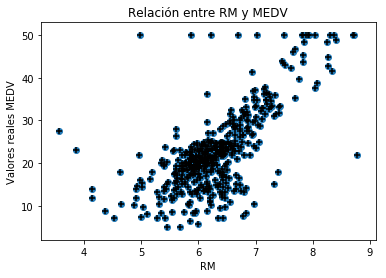

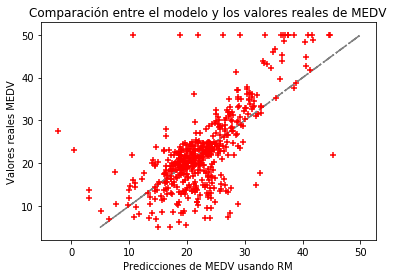

In [12]:
# Graficamos la variable X contra la variable Y
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.scatter(X, y)
plt.xlabel("RM")
plt.ylabel("Valores reales MEDV")
plt.title('Relación entre RM y MEDV')
plt.show()

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de MEDV usando RM")
plt.ylabel("Valores reales MEDV")
plt.title('Comparación entre el modelo y los valores reales de MEDV')
plt.show()

In [13]:
print ("EMC:", mean_squared_error(y, predictions)) # error medio cuadrático
sum_mod(model, X)

EMC: 43.60055177116956


,0
RM,9.102109
Intecept,-34.670621
R2,0.483525


* ¿Qué pueden decir al comparar los dos gráficos? ¿Cómo interpretan el último gráfico ? ¿Qué les dice acerca del modelo? ¿Qué pueden decir acerca de la relación entre RM y MEDV? 

* Repitamos ahora lo anterior pero usando otra variable...


El primer gráfico tiene como objetivo evaluar si existe algún tipo de relacion lineal entre la variable explicativa y la variable objetivo. En particular con estas variables se observa que hay cierta correlación entre ellas, puesto que cuando el número de Habitaciones promedio aumenta, el precio medio de la zona también aumenta, lo cual tiene cierto sentido. 
 
 El segundo gráfico es la comparación entre el **valor real observado** vs el **valor predicho** por nuestro modelo. Es decir obtuvimos cuál es la relación entre la variable RM y MEDV a través de un vector de coeficientes y un intercepto.
 
 Como se interpreta el **EMC** porque usamos esa metrica? existe alguna mejor que otra? Que es el R2, puede dar negativo?. 
 
 Algunos recursos para repasar estos [conceptos](https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914)

## Relación entre LSTAT y MEDV

De manera muy simmilar al ejercicio anterior, observamos si existe relación entre la variable LSTAT (porcentaje con menos status o menor poder adquisitivo de la población) y el precio promedio (MEDV). Esta variable (LSTAT) podría tener alguna relación inversa con la variable objetivo (precios), puesto que podemos inferir que mientras mayor es el porcentaje de la población que tiene menor poder adquisitivo, más baratas (en promedio) deberían ser las casas. Por lo que esperamos una relación inversa entre el índice LSTAT y la variable objetivo. 

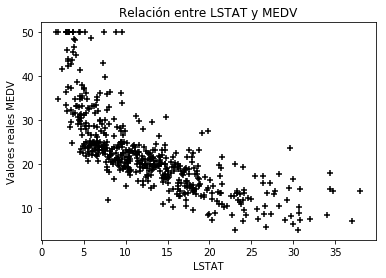

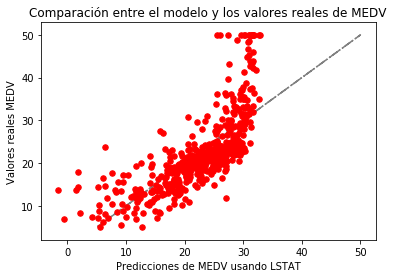

EMC: 38.48296722989414


,0
LSTAT,-0.950049
Intecept,34.553841
R2,0.544146


In [14]:
# Instanciamos el nuevo modelo.
lm = linear_model.LinearRegression()

#  Seleccionamos la variable a testear.
X = df[["LSTAT"]]
y = targets["MEDV"]

# Fiteamos y realizamos las predicciones.
model = lm.fit(X, y)
predictions = lm.predict(X)

# Graficamos la variable X contra la variable Y
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.xlabel("LSTAT")
plt.ylabel("Valores reales MEDV")
plt.title('Relación entre LSTAT y MEDV')
plt.show()

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='o', zorder=10)
plt.xlabel("Predicciones de MEDV usando LSTAT")
plt.ylabel("Valores reales MEDV")
plt.title('Comparación entre el modelo y los valores reales de MEDV')
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
sum_mod(model, X)

* ¿Qué pueden decir al comparar éste modelo y el anterior? 

Como anticipamos el coeficiente beta de la variable LSTAT es negativo. Cuál es la interpretación del intercepto?.

* Estimemos, ahora, un modelo usando las dos variables anteriores.

## Model lineal con dos variables. LSTAT y RM

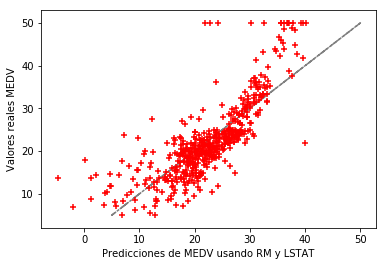

EMC: 30.51246877729947


In [15]:
# Instancio el modelo.
lm = linear_model.LinearRegression()

X = df[["RM", "LSTAT"]]
y = targets["MEDV"]

# Fiteo el modelo y hago las predicciones.
model = lm.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de MEDV usando RM y LSTAT")
plt.ylabel("Valores reales MEDV")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
prevMSE = mean_squared_error(y, predictions)

In [16]:
sum_mod(model, X)

,0
RM,5.094788
LSTAT,-0.642358
Intecept,-1.358273
R2,0.638562


Al utilizar las dos variables que pasa con el ajuste de la regresión?. Como es la interpretación de los coeficientes?

## Comparando los modelos

Un modelo perfecto se vería como una línea recta a 45 grados como la que vemos en gris. Ya veremos cómo cuantificar la bondad de ajuste pronto.

### Ejercicio


<div id="caja3" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/en_accion.png" style="align:left"/> </div>
  <div style="float:left;width: 85%;"><label>Ajustar el modelo usando TODAS las variables, usando `X = df`. Esto mejora el ajuste? (comparar el EMC).</label></div>
</div>


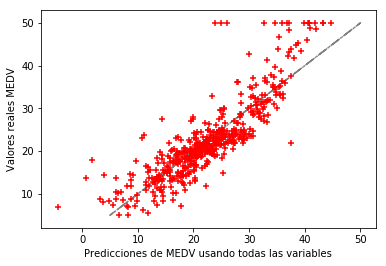

EMC: 21.894831181729202
¿Mejora?:  True
                  0
CRIM      -0.108011
ZN         0.046420
INDUS      0.020559
CHAS       2.686734
NOX      -17.766611
RM         3.809865
AGE        0.000692
DIS       -1.475567
RAD        0.306049
TAX       -0.012335
PTRATIO   -0.952747
B          0.009312
LSTAT     -0.524758
Intecept  36.459488
R2         0.740643


In [17]:
lm = linear_model.LinearRegression()

#X = df[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']]

#Otra opción para definir X
X = df[list(df.columns.values)]

y = targets["MEDV"]

model = lm.fit(X, y)
predictions = model.predict(X)

# Graficamos el modelo
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de MEDV usando todas las variables")
plt.ylabel("Valores reales MEDV")
plt.show()
print ("EMC:", mean_squared_error(y, predictions))
print ("¿Mejora?: ", mean_squared_error(y, predictions) < prevMSE)

print (sum_mod(model, X))

<div class="alert alert-block alert-success">
<b>Conclusiones:</b> 
    En la primera aproximación evaluamos variables explicativas como RM y LSTAT. De cada variable relevada el modelo de regresión lineal muestra un R cuadrado (R2) de 0.48 y 0.54 respectivamente. Al combinar ambas en un modelo de regresion multiple el R2 aumenta a 0.63 con un EMC de 30.   
    
Por último ejercicio incluye agregar todas las variables del dataset para generar y ajustar  a un modelo multiple con 13 variables explicativas. En consecuencia obtenemos un modelo con un R2 de 0.74 y un EMC de 21   
    
</div>

## Introducción a Statsmodels

### Statsmodels vs sklearn. 
Si ya estamos familiarizados con scikit-learn porque usar otra libreria?. Como vimos en clase hay muchos supuestos detrás de un simple modelo regresión lineal. Por ende si deseamos un análisis estadístico completo  de los p-values de los coeficientes, desvío estándar, errores de cada parámetro, test-t o algún otro, necesitaremos mudarnos de librería.  


Veamos ahora cómo se usa otra librería popular para realizar regresiones como Statsmodels.

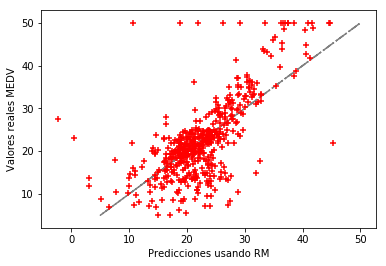

EMC: 43.60055177116956
                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Thu, 02 Jul 2020   Prob (F-statistic):           2.49e-74
Time:                        17:00:56   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.6706      2.

In [18]:
# Importamos la api.
import statsmodels.api as sm

# De manera análoga a la vista en el primer ejercicio, definimos el vector de variables con la primer variable RM.
X = df[["RM"]]
y = targets[["MEDV"]]

# Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Graficamos los resultados
plt.plot(y,y, '-.', c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando RM")
plt.ylabel("Valores reales MEDV")
plt.show()

# Imprimimos el MSE y un resumen del modelo
print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

Que podemos decir del p-value para la variable RM. 


* ¿Cómo fue la performance de esta libreria (comparar ECM con sklearn)? 
* ¿Que puede decirse del coeficiente de RM?¿Es significativo?¿Que significa esto?
* ¿ Que es el 'R ajustado'? ¿Para que sirve?

## Referencias


<div id="caja8" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/para_saber_mas.png" style="align:left"/> </div>
  <div style="float:left;width: 85%;"><label></label></div>
</div>


Recursos extra: 
* Si queres entender de manera interactiva las regresiones lineales no dejes de ver este [recurso](http://setosa.io/ev/ordinary-least-squares-regression).

* Repaso de conceptos: [R ajustado:](https://www.statisticshowto.datasciencecentral.com/adjusted-r2/)